In [1]:
import os
import matplotlib.pyplot as plt
import torch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from helper.ECI_regression import ExpectedCoverageImprovement_regression
SMOKE_TEST = os.environ.get("SMOKE_TEST")


If no GPU change "cuda" to "cpu"

In [2]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.double,
}

In [3]:
def get_and_fit_gp(X, Y):
    """Simple method for creating a GP with one output dimension.

    X is assumed to be in [0, 1]^d.
    """
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))  # Noise-free
    # octf = Standardize(m=Y.shape[-1])
    # gp = SingleTaskGP(X, Y, likelihood=likelihood, outcome_transform=octf)
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [4]:
def hills(x):
    v = 0.5*torch.cos(x[:,0]*2-torch.pi)+torch.sin(x[:,1]+torch.pi/2)
    
    return torch.stack((v, v), dim=-1)

In [5]:
def circle(x):
    v = -(x[:,0] ** 2 + x[:,1] ** 2) + 25
    return torch.stack((v, v), dim=-1)

In [6]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

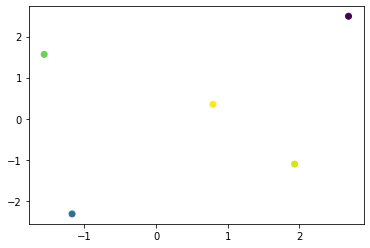

In [7]:
import copy
num_init_points = 5
num_total_points = 20
Xhills = lb + (ub - lb) * SobolEngine(dim, scramble=True).draw(num_init_points).to(**tkwargs)
Yhills = hills(Xhills)
Xcircle = copy.deepcopy(Xhills)
Ycircle = circle(Xcircle)
plt.scatter(Xhills.cpu().numpy()[:, 0], Xhills.cpu().numpy()[:, 1], c=Yhills.cpu()[:,0])

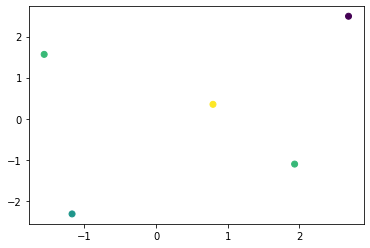

In [8]:
plt.scatter(Xcircle.cpu().numpy()[:, 0], Xcircle.cpu().numpy()[:, 1], c=Ycircle.cpu()[:,0])

In [9]:
constraints = [("lt", 2), ("gt", 0.3), ("lt", 30), ("gt", 20)]

# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std
i = 1
while len(Xhills) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    gp_model_hills = [get_and_fit_gp(Xhills, Yhills[:, i : i + 1]) for i in range(Yhills.shape[-1])]
    gp_model_circle = [get_and_fit_gp(Xcircle, Ycircle[:, i : i + 1]) for i in range(Ycircle.shape[-1])]
    model_list_gp = ModelListGP(gp_model_hills[0], gp_model_hills[1], gp_model_circle[0], gp_model_circle[1])

    eci = ExpectedCoverageImprovement_regression(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512 if not SMOKE_TEST else 4,
    )

    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10 if not SMOKE_TEST else 2,
        raw_samples=512 if not SMOKE_TEST else 4,
    )

    print(f"New X No. {i}")
    i += 1
    y_next_hills = hills(x_next)
    y_next_circle = circle(x_next)

    Xhills = torch.cat((Xhills, x_next))
    Xcircle = torch.cat((Xcircle, x_next))
    Yhills = torch.cat((Yhills, y_next_hills))
    Ycircle = torch.cat((Ycircle, y_next_circle))

New X No. 1
New X No. 2
New X No. 3
New X No. 4
New X No. 5
New X No. 6
New X No. 7
New X No. 8
New X No. 9
New X No. 10
New X No. 11
New X No. 12
New X No. 13
New X No. 14
New X No. 15


In [10]:
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)
    for model_index in range(X.shape[-1]):
        these_X = X[..., model_index]
        direction, value = constraints[model_index]
        successful[..., model_index] = (
            these_X < value if direction == "lt" else these_X > value
        )
    return successful

In [11]:
N1, N2 = 500, 500
Xplt_hills, Yplt_hills = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt_hills = torch.stack(
    (
        torch.reshape(Xplt_hills, (Xplt_hills.shape[0] * Xplt_hills.shape[1],)),
        torch.reshape(Yplt_hills, (Yplt_hills.shape[0] * Yplt_hills.shape[1],)),
    ),
    dim=1,
)
yplt_hills = hills(xplt_hills)
Zplt_hills = torch.reshape(yplt_hills[:, 0], (N1, N2)) 

feasible_inds_hills = (
    identify_samples_which_satisfy_constraints(Yhills, constraints[:2])
    .prod(dim=-1)
    .to(torch.bool)
)

c:\Program Files\Python310\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
Xplt_circle, Yplt_circle = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt_circle = torch.stack(
    (
        torch.reshape(Xplt_circle, (Xplt_circle.shape[0] * Xplt_circle.shape[1],)),
        torch.reshape(Yplt_circle, (Yplt_circle.shape[0] * Yplt_circle.shape[1],)),
    ),
    dim=1,
)
yplt_circle = circle(xplt_circle)
Zplt_circle = torch.reshape(yplt_circle[:, 0], (N1, N2)) 

feasible_inds_circle = (
    identify_samples_which_satisfy_constraints(Ycircle, constraints[2:])
    .prod(dim=-1)
    .to(torch.bool)
)


In [13]:
Xhills[feasible_inds_hills, 0].shape

torch.Size([13])

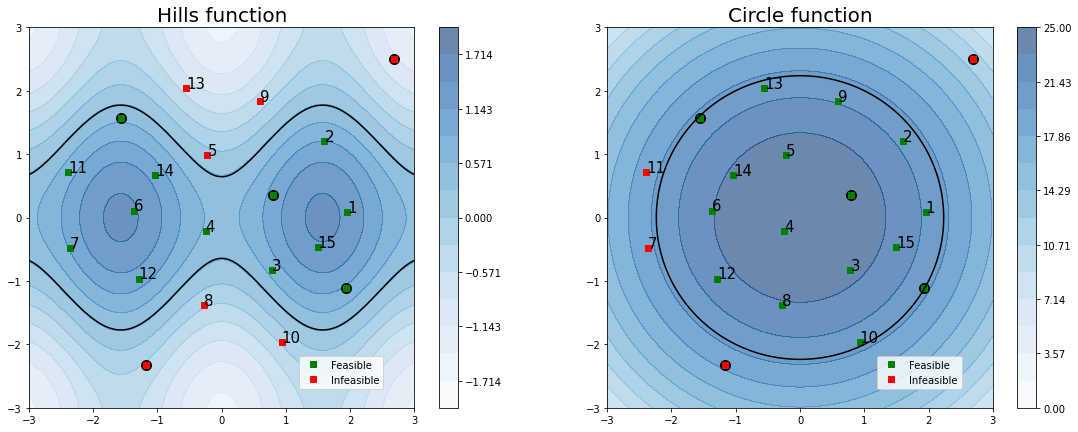

In [14]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))
plot1 = ax[0].contourf(Xplt_hills.cpu(), Yplt_hills.cpu(), Zplt_hills.cpu(), levels=np.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].plot(Xhills[feasible_inds_hills, 0].cpu(), Xhills[feasible_inds_hills, 1].cpu(), "sg", label="Feasible")
ax[0].plot(
    Xhills[~feasible_inds_hills, 0].cpu(), Xhills[~feasible_inds_hills, 1].cpu(), "sr", label="Infeasible"
)
ax[0].scatter(Xhills.cpu()[:5, 0], Xhills.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ind = 1

for i in Xhills[5:]:
    ax[0].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[0].legend(loc=[0.7, 0.05])
ax[0].set_title('Hills function', fontsize=20)

ax[0].contour(Xplt_hills.cpu(), Yplt_hills.cpu(), Zplt_hills.cpu(), [constraints[1][1], constraints[0][1]], colors="k")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].contourf(Xplt_circle.cpu(), Yplt_circle.cpu(), Zplt_circle.cpu(), levels=np.linspace(0, 25, 15), cmap="Blues", alpha=0.6)
ax[1].plot(Xcircle[feasible_inds_circle, 0].cpu(), Xcircle[feasible_inds_circle, 1].cpu(), "sg", label="Feasible")
ax[1].plot(
    Xcircle[~feasible_inds_circle, 0].cpu(), Xcircle[~feasible_inds_circle, 1].cpu(), "sr", label="Infeasible"
)
ax[1].scatter(Xcircle.cpu()[:5, 0], Xcircle.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ax[1].contour(Xplt_circle.cpu(), Yplt_circle.cpu(), Zplt_circle.cpu(), [constraints[3][1], constraints[2][1]], colors="k")
ind = 1
for i in Xcircle[5:]:
    ax[1].text(i[0],i[1],ind, size = 15)
    ind += 1
ax[1].legend(loc=[0.7, 0.05])
ax[1].set_title('Circle function', fontsize=20)
fig.colorbar(plot2, location='right')


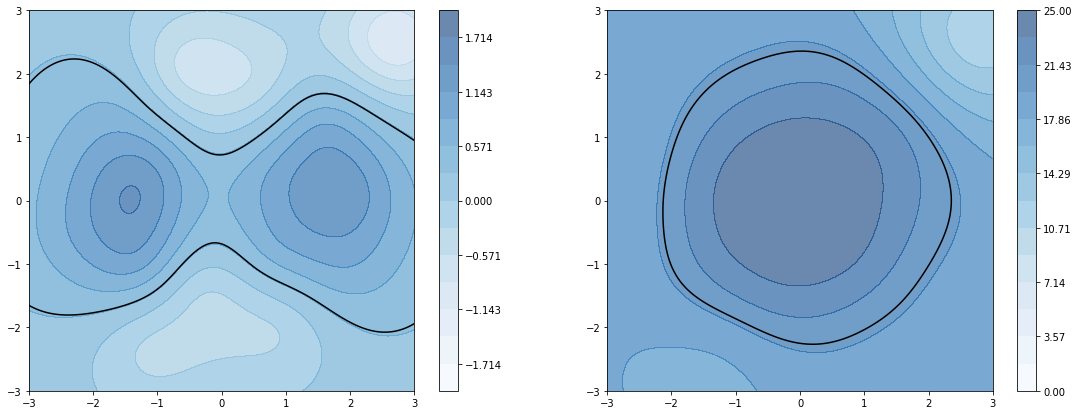

In [15]:
Xplt, Yplt = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
pos_yplt_hills = gp_model_hills[0](xplt).loc
pos_yplt_circle = gp_model_circle[0](xplt).loc

pos_Zplt_hills = torch.reshape(pos_yplt_hills, (N1, N2))
pos_Zplt_circle = torch.reshape(pos_yplt_circle, (N1, N2)) 
fig, ax = plt.subplots(1,2, figsize=(19, 7))
h1 = ax[0].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_hills.cpu().detach(), levels=np.linspace(-2, 2, 15), cmap="Blues", alpha=0.6)
ax[0].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_hills.cpu().detach(), [0.3, 2], colors="k")
fig.colorbar(h1, ax=ax[0])

h2 = ax[1].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_circle.cpu().detach(), levels=np.linspace(0, 25, 15), cmap="Blues", alpha=0.6)
ax[1].contour(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_Zplt_circle.cpu().detach(), [20, 30], colors="k")
fig.colorbar(h2, ax=ax[1])


Manual posterior sampling

In [16]:
manual = torch.tensor([[0, 0]], **tkwargs)

gp_model_hills[0](manual).loc

tensor([0.5487], dtype=torch.float64, grad_fn=<ViewBackward0>)

True overlap

Text(0.5, 1.0, 'Estimated boundary')

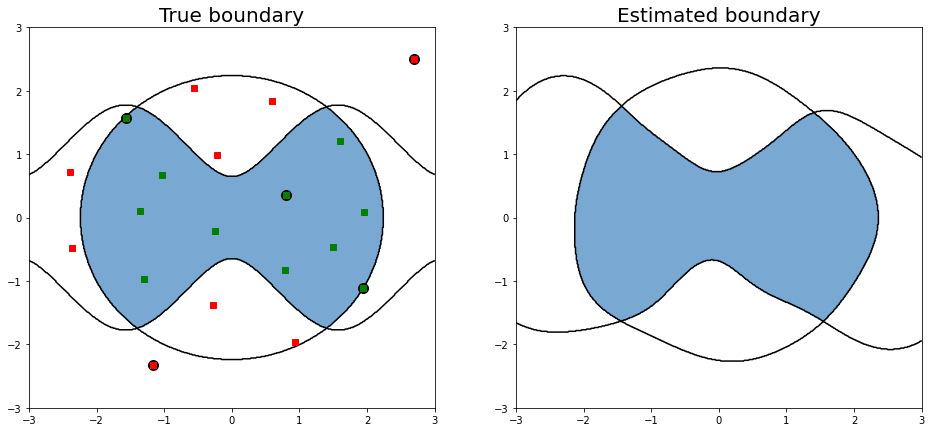

In [17]:
true_overlap = (Zplt_hills > 0.3) & (Zplt_circle > 20)
constraints_list = [constraints[1][1], constraints[0][1]]

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), true_overlap.cpu().detach(), levels=np.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[0].contour(Xplt_hills.cpu().detach(), Yplt_hills.cpu().detach(), (Zplt_hills>0.3).cpu().detach(), constraints_list, colors="k")
ax[0].contour(Xplt_circle.cpu().detach(), Yplt_circle.cpu().detach(), (Zplt_circle>20).cpu().detach(), constraints_list, colors="k")
ax[0].scatter(Xhills.cpu()[:5, 0], Xhills.cpu()[:5, 1], marker = 'o', s=100, color = 'k')
ax[0].set_title("True boundary", fontsize=20)

true_overlap_points = feasible_inds_circle & feasible_inds_hills
ax[0].plot(Xhills[true_overlap_points, 0].cpu(), Xhills[true_overlap_points, 1].cpu(), "sg", label="Feasible")
ax[0].plot(
    Xhills[~true_overlap_points, 0].cpu(), Xhills[~true_overlap_points, 1].cpu(), "sr", label="Infeasible"
)

pos_overlap = (pos_Zplt_hills > 0.3) & (pos_Zplt_circle > 20)
constraints_list = [constraints[1][1], constraints[0][1]]

ax[1].contourf(Xplt.cpu().detach(), Yplt.cpu().detach(), pos_overlap.cpu().detach(), levels=np.linspace(0.1,1,3), cmap="Blues", alpha=0.6)
ax[1].contour(Xplt_hills.cpu().detach(), Yplt_hills.cpu().detach(), (pos_Zplt_hills>0.3).cpu().detach(), constraints_list, colors="k")
ax[1].contour(Xplt_circle.cpu().detach(), Yplt_circle.cpu().detach(), (pos_Zplt_circle>20).cpu().detach(), constraints_list, colors="k")
ax[1].set_title("Estimated boundary", fontsize=20)

Note for revision:
1. Deprecate different Xplt_***
2. Change constraints

Comment it out if no GPU

In [18]:
# import gc
# import torch
# gc.collect()
# torch.cuda.empty_cache()